### setting up 

In [1]:
import sys, os
notebook_dir = os.getcwd()
sys.path.append(os.path.join(notebook_dir, "submodules", "vggt"))

In [2]:
import torch
from submodules.vggt.vggt.models.vggt import VGGT
from submodules.vggt.vggt.utils.load_fn import load_and_preprocess_images
from pc_inference import load_images, load_model, pc_inference

import open3d as o3d
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### usage 

In [3]:
img_folder_path = "data/leonora/ship_of_cranes/images"
model_path = "submodules/vggt/checkpoints/model.pt"
# model inference 
images, ori_size = load_images(path_images=img_folder_path)
model = load_model(model_path=model_path)
predictions = pc_inference(
    model=model, images=images, use_point_map=False, init_conf_threshold=50
)

Loading model...
Running VGGT inference...
Converting pose encoding to extrinsic and intrinsic matrices...
Processing model outputs...


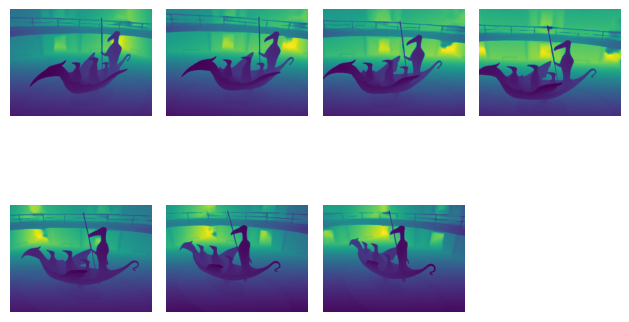

In [9]:
for i in range(images.shape[0]):
    plt.subplot(2, 4, i + 1)
    plt.imshow(predictions["depth_maps"][i])
    plt.axis("off")
    plt.tight_layout()